# **Bowtie metrics**

## 0 - Previous requirements

### Install requirements

In [57]:
# Olivia Finder requirements
%pip install networkx pandas matplotlib scipy

Note: you may need to restart the kernel to use updated packages.


: 

In [34]:
from time import time
import os
from typing import Any
import psutil
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt


## Bowtie Structure

This function takes a network as input and returns a node set decomposition based on the tie-loop structure of the input network. The function uses the algorithm described in the article "Bow-tie decomposition in directed graphs" by R. Yang, L. Zhuhadar and O. Nasraoui.

The function starts by finding the largest strongly connected component of the input network using the `max` function of the `networkx` library. Next, an arbitrary node of the largest strongly connected component is selected and the forward and backward reachable nodes from the largest strongly connected component are computed using the `dfs_tree` function of the `networkx` library.

Next, the input and output components of the tie-loop structure are computed using the forward and backward reachable nodes. Nodes that are forward reachable but not backward make up the output component, while nodes that are backward reachable but not forward make up the input component.

After calculating the input and output components, the "tendril", "tube" and "disconnected" components are calculated. Nodes that are reachable forward and backward form a "pipe", nodes that are reachable backward but not forward form an input "tendril", nodes that are reachable forward but not backward form a "tendril". " output, and nodes that are neither forward nor backward reachable are considered disconnected.

Finally, the function returns the node sets for each component of the tie-loop structure: the largest strongly connected component, the input and output components, the "tendril", "tube", and "disconnected" components.

In short, this function is used to decompose a network into its bow-tie structure components using the algorithm described in the article "Bow-tie decomposition in directed graphs". The function returns the node sets for each component of the tie-loop structure, which can be useful for analyzing the network structure and understanding its behavior.

In [37]:
def bowtie_structure(network):
    """ 
    Return node set decomposition according to the bowtie structure of the input network.
    Algorithm from 
    R. Yang, L. Zhuhadar and O. Nasraoui, "Bow-tie decomposition in directed graphs",2011
    """
    
    largest_scc = max(nx.strongly_connected_components(network), key=len)
    
    # Arbitrary node from the largest SCC
    node = next(iter(largest_scc))
    
    # Reachable nodes (forward) from the largest SCC
    dfs = set(nx.dfs_tree(network,node).nodes())
    
    # Reachable nodes (backwards) from the largest SCC
    reversed_network = nx.reverse(network, copy=True)
    dfs_t = set(nx.dfs_tree(reversed_network,node).nodes())
    
    out_component = dfs - largest_scc
    in_component = dfs_t - largest_scc
    
    # Tendrils, tubes and disconnected components
    rest = set(network.nodes()) -  largest_scc - out_component - in_component

    tubes, in_tendrils, out_tendrils, disconnected  = set(), set(), set(), set()

    for v in rest:
        # in_component nodes backwards reachable from v
        irv = in_component & set(nx.dfs_tree(reversed_network, v).nodes())
        # out_component nodes reachable from v
        vro = out_component & set(nx.dfs_tree(network, v).nodes())
        
        if irv and vro:
            tubes.add(v)
        elif irv and not vro:
            in_tendrils.add(v)
        elif not irv and vro:
            out_tendrils.add(v)
        else:
            disconnected.add(v)
            
    return  largest_scc, in_component, out_component, tubes, in_tendrils, out_tendrils, disconnected

In [38]:
def add_chunk(
    df, G, dependent_field, dependency_field,
    filter_field=None,
    filter_value=None
):
    """ Utility method for build_dependency_network"""

    filtered = df[df[filter_field] == filter_value] if filter_field else df
    links = list(zip(filtered[dependency_field], filtered[dependent_field]))
    G.add_edges_from(links)
    return G

def build_dependency_network(
    input_file,
    output_file,
    chunk_size,
    dependent_field: str = 'Project Name',
    dependency_field: str = 'Dependency Name',
    filter_field = None,
    filter_value = None,
    verbose: bool = True
) -> None:

    """
    Builds a dependency network from a file with package dependencies information

    Reads from a CSV file and writes to a txt file with adjacency lists
    corresponding to network model. Compression methods are inferred from file
    extension (.gz and .bz2 are supported from NetworkX IO methods)

    Parameters
    ----------
    input_file : str
        Path to csv file with dependencies information
    output_file : str
        Path to write resulting network file
    chunk_size : int
        Amount of lines to be read at once from input_file in batch  processing.
    dependent_field : str
        DataFrame column Id for the dependent package
    dependency_field : str
        Dataframe column Id for the dependency package
    filter_field : str, optional
        If not None, only add records where filter_field equals filter_value
    filter_value : str, optional
        If not None, only add records where filter_field equals filter_value
    verbose: bool, optional
        If True, processing information is written to standard output.
    Returns
    -------
        None
    """

    # Print only if verbose
    vprint = print if verbose else lambda *a, **k: None
    process = psutil.Process(os.getpid())
    vprint("Using process ", process)
    t = time()
    try:
        vprint(f'Opening "{input_file}"... ', end='')
        # Obtain reader iterator
        reader = pd.read_csv(input_file, chunksize=chunk_size)
        vprint('OK')
        vprint('Initializing graph... ', end='')
        # New NetworkX directed Graph
        G = nx.DiGraph()
        vprint('OK')
        for i, chunk in enumerate(reader):
            # Add dependencies from chunk to G
            add_chunk(
                chunk, 
                G,
                dependent_field=dependent_field,
                dependency_field=dependency_field,
                filter_field=filter_field,
                filter_value=filter_value
            )
            vprint(f'{round(i*chunk_size/1e6,1)}M lines | {len(G)} nodes,{len(G.edges)} deps. ({int(time()-t)}s) {round(process.memory_info().rss/1e6,1)}Mb ')
        vprint('Done reading file')
        vprint(f'Saving network as "{output_file}"... ', end='')
        nx.write_adjlist(G, output_file)
        vprint('OK')
    except Exception as e:
        print('\n', e)

## Analysis

Set up in/out files

In [39]:
libraries_cran_csv = "../olivia_finder/results/csv_datasets/cran/cran_adjlist_librariesio_filtered.csv"
libraries_cran_adjlist = "../olivia_finder/results/network_models/cran_adjlist_librariesio_filtered.bz2"
scraped_cran_csv = "../olivia_finder/results/csv_datasets/cran/cran_adjlist_scraping.csv"
scraped_cran_adjlist = "../olivia_finder/results/network_models/cran_adjlist_scraping.bz2"

# libraries_bioconductor_csv = ""
# libraries_bioconductor_adjlist = ""
scraped_bioconductor_csv = "../olivia_finder/results/csv_datasets/bioconductor/bioconductor_adjlist_scraping.csv"
scraped_bioconductor_adjlist = "../olivia_finder/results/network_models/bioconductor_adjlist_scraping.bz2"

libraries_pypi_csv = "../olivia_finder/results/csv_datasets/pypi/pypi_adjlist_librariesio_filtered.csv"
libraries_pypi_adjlist = "../olivia_finder/results/network_models/pypi_adjlist_librariesio_filtered.bz2"
scraped_pypi_csv = "../olivia_finder/results/csv_datasets/pypi/pypi_adjlist_scraping.csv"
scraped_pypi_adjlist = "../olivia_finder/results/network_models/pypi_adjlist_scraping.bz2"

libraries_npm_csv = "../olivia_finder/results/csv_datasets/npm/npm_adjlist_librariesio_filtered.csv"
libraries_npm_adjlist = "../olivia_finder/results/network_models/npm_adjlist_librariesio_filtered.bz2"
scraped_npm_csv = "../olivia_finder/results/csv_datasets/npm/npm_adjlist_scraping.csv"
scraped_npm_adjlist = "../olivia_finder/results/network_models/npm_adjlist_scraping.bz2"

### Bioconductor bowtie

Build network graph

In [40]:
build_dependency_network(
    input_file=scraped_bioconductor_csv,
    output_file=scraped_bioconductor_adjlist,
    chunk_size=1e4,
    dependent_field='name',
    dependency_field='dependency',
    verbose=True
)
scraped_bioconductor_G = nx.read_adjlist(scraped_bioconductor_adjlist, create_using=nx.DiGraph)

Using process  psutil.Process(pid=15393, name='python', status='running', started='15:42:46')
Opening "../olivia_finder/results/csv_datasets/bioconductor/bioconductor_adjlist_scraping.csv"... OK
Initializing graph... OK
0.0M lines | 1783 nodes,9999 deps. (0s) 951.7Mb 
0.0M lines | 2787 nodes,19994 deps. (0s) 955.0Mb 
0.0M lines | 3509 nodes,28320 deps. (0s) 957.5Mb 
Done reading file
Saving network as "../olivia_finder/results/network_models/bioconductor_adjlist_scraping.bz2"... OK


Calc metrics for scraped network

In [41]:
bio_largest_scc, bio_in_component, bio_out_component, bio_tubes, bio_in_tendrils, bio_out_tendrils, bio_disconnected = bowtie_structure(scraped_bioconductor_G)

checks = len(bio_largest_scc)+\
len(bio_in_component)+\
len(bio_out_component)+\
len(bio_tubes)+\
len(bio_in_tendrils)+\
len(bio_out_tendrils)+\
len(bio_disconnected) == len(scraped_bioconductor_G.nodes())

if checks:
    print("Sum of all components equals total number of nodes")

print(f"Bioconductor bowtie structure:\n\
      Largest SCC: {len(bio_largest_scc)}\n\
      In component: {len(bio_in_component)}\n\
      Out component: {len(bio_out_component)}\n\
      Tubes: {len(bio_tubes)}\n\
      In tendrils: {len(bio_in_tendrils)}\n\
      Out tendrils: {len(bio_out_tendrils)}\n\
      Disconnected: {len(bio_disconnected)}")

Sum of all components equals total number of nodes
Bioconductor bowtie structure:
      Largest SCC: 1
      In component: 124
      Out component: 0
      Tubes: 0
      In tendrils: 2161
      Out tendrils: 0
      Disconnected: 1223


### CRAN bowtie comparation

In [42]:
# Build bioconductor graph
build_dependency_network(
    input_file=libraries_cran_csv,
    output_file=libraries_cran_adjlist,
    chunk_size=1e4,
    dependent_field='Project Name',
    dependency_field='Dependency Name',
    verbose=True
)
librariesio_cran_G = nx.read_adjlist(libraries_cran_adjlist, create_using=nx.DiGraph)


build_dependency_network(
    input_file=scraped_cran_csv,
    output_file=scraped_cran_adjlist,
    chunk_size=1e4,
    dependent_field='name',
    dependency_field='dependency',
    verbose=True
)
scraped_cran_G = nx.read_adjlist(scraped_cran_adjlist, create_using=nx.DiGraph)

Using process  psutil.Process(pid=15393, name='python', status='running', started='15:42:46')
Opening "../olivia_finder/results/csv_datasets/cran/cran_adjlist_librariesio_filtered.csv"... OK
Initializing graph... OK
0.0M lines | 2986 nodes,9960 deps. (0s) 952.8Mb 
0.0M lines | 5229 nodes,19901 deps. (0s) 956.9Mb 
0.0M lines | 7896 nodes,29860 deps. (0s) 961.7Mb 
0.0M lines | 9816 nodes,39841 deps. (0s) 965.7Mb 
0.0M lines | 11440 nodes,49801 deps. (0s) 969.5Mb 
0.1M lines | 13065 nodes,59743 deps. (0s) 973.4Mb 
0.1M lines | 14612 nodes,69735 deps. (0s) 977.1Mb 
0.1M lines | 15647 nodes,76207 deps. (0s) 979.2Mb 
Done reading file
Saving network as "../olivia_finder/results/network_models/cran_adjlist_librariesio_filtered.bz2"... OK
Using process  psutil.Process(pid=15393, name='python', status='running', started='15:42:46')
Opening "../olivia_finder/results/csv_datasets/cran/cran_adjlist_scraping.csv"... OK
Initializing graph... OK
0.0M lines | 3012 nodes,9999 deps. (0s) 979.6Mb 
0.0M l

In [43]:
cran_largest_scc, cran_in_component, cran_out_component, \
cran_tubes, cran_in_tendrils, cran_out_tendrils, cran_disconnected = bowtie_structure(librariesio_cran_G)

checks = len(cran_largest_scc)+\
len(cran_in_component)+\
len(cran_out_component)+\
len(cran_tubes)+\
len(cran_in_tendrils)+\
len(cran_out_tendrils)+\
len(cran_disconnected) == len(librariesio_cran_G)

if checks:
    print("Sum of all components equals total number of nodes")

print(f"Cran bowtie structure:\n\
        Largest SCC: {len(cran_largest_scc)}\n\
        In component: {len(cran_in_component)}\n\
        Out component: {len(cran_out_component)}\n\
        Tubes: {len(cran_tubes)}\n\
        In tendrils: {len(cran_in_tendrils)}\n\
        Out tendrils: {len(cran_out_tendrils)}\n\
        Disconnected: {len(cran_disconnected)}")

Sum of all components equals total number of nodes
Cran bowtie structure:
        Largest SCC: 1
        In component: 79
        Out component: 0
        Tubes: 0
        In tendrils: 14980
        Out tendrils: 0
        Disconnected: 587


In [44]:
cran_largest_scc_2, cran_in_component_2, cran_out_component_2, \
cran_tubes_2, cran_in_tendrils_2, cran_out_tendrils_2, cran_disconnected_2 = bowtie_structure(scraped_cran_G)

checks = len(cran_largest_scc_2)+\
len(cran_in_component_2)+\
len(cran_out_component_2)+\
len(cran_tubes_2)+\
len(cran_in_tendrils_2)+\
len(cran_out_tendrils_2)+\
len(cran_disconnected_2) == len(scraped_cran_G)

if checks:
    print("Sum of all components equals total number of nodes")

print(f"Cran bowtie structure:\n\
        Largest SCC: {len(cran_largest_scc_2)}\n\
        In component: {len(cran_in_component_2)}\n\
        Out component: {len(cran_out_component_2)}\n\
        Tubes: {len(cran_tubes_2)}\n\
        In tendrils: {len(cran_in_tendrils_2)}\n\
        Out tendrils: {len(cran_out_tendrils_2)}\n\
        Disconnected: {len(cran_disconnected_2)}")

Sum of all components equals total number of nodes
Cran bowtie structure:
        Largest SCC: 1
        In component: 6
        Out component: 0
        Tubes: 0
        In tendrils: 17984
        Out tendrils: 0
        Disconnected: 680


### Pypi Bowtie comparation

Build network graphs

In [45]:
build_dependency_network(
    input_file=libraries_pypi_csv,
    output_file=libraries_pypi_adjlist,
    chunk_size=1e4,
    dependent_field='Project Name',
    dependency_field='Dependency Name',
    verbose=True
)
librariesio_pypi_G = nx.read_adjlist(libraries_pypi_adjlist, create_using=nx.DiGraph)

build_dependency_network(
    input_file=scraped_pypi_csv,
    output_file=scraped_pypi_adjlist,
    chunk_size=1e4,
    dependent_field='name',
    dependency_field='dependency',
    verbose=True
)
scraped_pypi_G = nx.read_adjlist(scraped_pypi_adjlist, create_using=nx.DiGraph)

Using process  psutil.Process(pid=15393, name='python', status='running', started='15:42:46')
Opening "../olivia_finder/results/csv_datasets/pypi/pypi_adjlist_librariesio_filtered.csv"... OK
Initializing graph... OK
0.0M lines | 5155 nodes,9992 deps. (0s) 955.4Mb 
0.0M lines | 8560 nodes,19966 deps. (0s) 959.6Mb 
0.0M lines | 12063 nodes,29952 deps. (0s) 964.9Mb 
0.0M lines | 15418 nodes,39939 deps. (0s) 970.2Mb 
0.0M lines | 18740 nodes,49922 deps. (0s) 975.4Mb 
0.1M lines | 22171 nodes,59912 deps. (0s) 980.5Mb 
0.1M lines | 25629 nodes,69906 deps. (0s) 986.1Mb 
0.1M lines | 29269 nodes,79899 deps. (0s) 991.5Mb 
0.1M lines | 32768 nodes,89897 deps. (0s) 996.9Mb 
0.1M lines | 36460 nodes,99878 deps. (0s) 1002.5Mb 
0.1M lines | 40147 nodes,109875 deps. (0s) 1007.9Mb 
0.1M lines | 43649 nodes,119865 deps. (0s) 1013.3Mb 
0.1M lines | 47453 nodes,129809 deps. (0s) 1018.9Mb 
0.1M lines | 49306 nodes,134575 deps. (0s) 1021.2Mb 
Done reading file
Saving network as "../olivia_finder/results/ne

Calc metrics for librariesio network

In [46]:
pypi_largest_scc, pypi_in_component, pypi_out_component, pypi_tubes, pypi_in_tendrils, pypi_out_tendrils, pypi_disconnected = bowtie_structure(librariesio_pypi_G)

# Check that the sum of all bowtie components is equal to the total number of nodes in the graph
checks = len(pypi_largest_scc)+\
len(pypi_in_component)+\
len(pypi_out_component)+\
len(pypi_tubes)+\
len(pypi_in_tendrils)+\
len(pypi_out_tendrils)+\
len(pypi_disconnected) == len(librariesio_pypi_G)

if checks:
    print("Sum of all bowtie components is equal to the total number of nodes in the graph")

print(f"Librariesio PyPI bowtie structure:\n\
      Largest SCC: {len(pypi_largest_scc)}\n\
      In component: {len(pypi_in_component)}\n\
      Out component: {len(pypi_out_component)}\n\
      Tubes: {len(pypi_tubes)}\n\
      In tendrils: {len(pypi_in_tendrils)}\n\
      Out tendrils: {len(pypi_out_tendrils)}\n\
      Disconnected: {len(pypi_disconnected)}")

Sum of all bowtie components is equal to the total number of nodes in the graph
Librariesio PyPI bowtie structure:
      Largest SCC: 4
      In component: 21
      Out component: 5
      Tubes: 1
      In tendrils: 27742
      Out tendrils: 11
      Disconnected: 21522


Calc metrics of scraped network

In [47]:
pypi_largest_scc_2, pypi_in_component_2, pypi_out_component_2, \
pypi_tubes_2, pypi_in_tendrils_2, pypi_out_tendrils_2, pypi_disconnected_2 = bowtie_structure(scraped_pypi_G)

# Check that the sum of all bowtie components is equal to the total number of nodes in the graph
checks = len(pypi_largest_scc_2)+\
len(pypi_in_component_2)+\
len(pypi_out_component_2)+\
len(pypi_tubes_2)+\
len(pypi_in_tendrils_2)+\
len(pypi_out_tendrils_2)+\
len(pypi_disconnected_2) == len(scraped_pypi_G)

if checks:
    print("Sum of all bowtie components is equal to the total number of nodes in the graph")

print(f"Scraped PyPI bowtie structure:\n\
        Largest SCC: {len(pypi_largest_scc_2)}\n\
        In component: {len(pypi_in_component_2)}\n\
        Out component: {len(pypi_out_component_2)}\n\
        Tubes: {len(pypi_tubes_2)}\n\
        In tendrils: {len(pypi_in_tendrils_2)}\n\
        Out tendrils: {len(pypi_out_tendrils_2)}\n\
        Disconnected: {len(pypi_disconnected_2)}")


Sum of all bowtie components is equal to the total number of nodes in the graph
Scraped PyPI bowtie structure:
        Largest SCC: 283
        In component: 449
        Out component: 138219
        Tubes: 2446
        In tendrils: 30261
        Out tendrils: 14941
        Disconnected: 27871


### NPM Bowtie comparation

In [55]:
build_dependency_network(
    input_file=libraries_npm_csv,
    output_file=libraries_npm_adjlist,
    chunk_size=1e4,
    dependent_field='Project Name',
    dependency_field='Dependency Name',
    verbose=True
)
librariesio_npm_G = nx.read_adjlist(libraries_npm_adjlist, create_using=nx.DiGraph)

build_dependency_network(
    input_file=scraped_npm_csv,
    output_file=scraped_npm_adjlist,
    chunk_size=1e6,
    dependent_field='name',
    dependency_field='dependency',
    verbose=True
)
scraped_npm_G = nx.read_adjlist(scraped_npm_adjlist, create_using=nx.DiGraph)

Using process  psutil.Process(pid=15393, name='python', status='running', started='15:42:46')
Opening "../olivia_finder/results/csv_datasets/npm/npm_adjlist_scraping.csv"... OK
Initializing graph... OK
0.0M lines | 245059 nodes,1000000 deps. (5s) 3264.1Mb 
1.0M lines | 482752 nodes,2000000 deps. (12s) 3806.2Mb 
2.0M lines | 698525 nodes,3000000 deps. (16s) 4333.5Mb 
3.0M lines | 888042 nodes,4000000 deps. (24s) 4821.8Mb 
4.0M lines | 1059780 nodes,4855094 deps. (28s) 5216.2Mb 
Done reading file
Saving network as "../olivia_finder/results/network_models/npm_adjlist_scraping.bz2"... OK


In [49]:
npm_largest_scc, npm_in_component, npm_out_component, npm_tubes, npm_in_tendrils, npm_out_tendrils, npm_disconnected = bowtie_structure(librariesio_npm_G)

checks=len(npm_largest_scc)+\
len(npm_in_component)+\
len(npm_out_component)+\
len(npm_tubes)+\
len(npm_in_tendrils)+\
len(npm_out_tendrils)+\
len(npm_disconnected) == len(librariesio_npm_G)

if checks:
    print("Sum of all bowtie components is equal to the total number of nodes in the graph")

print(f"Librariesio NPM bowtie structure:\n\
    Largest SCC: {len(npm_largest_scc)}\n\
    In component: {len(npm_in_component)}\n\
    Out component: {len(npm_out_component)}\n\
    Tubes: {len(npm_tubes)}\n\
    In tendrils: {len(npm_in_tendrils)}\n\
    Out tendrils: {len(npm_out_tendrils)}\n\
    Disconnected: {len(npm_disconnected)}")

In [56]:
npm_largest_scc_2, npm_in_component_2, npm_out_component_2, \
npm_tubes_2, npm_in_tendrils_2, npm_out_tendrils_2, npm_disconnected_2 = bowtie_structure(scraped_npm_G)

checks=len(npm_largest_scc_2)+\
len(npm_in_component_2)+\
len(npm_out_component_2)+\
len(npm_tubes_2)+\
len(npm_in_tendrils_2)+\
len(npm_out_tendrils_2)+\
len(npm_disconnected_2) == len(scraped_npm_G)

if checks:
      print("Sum of all bowtie components is equal to the total number of nodes in the graph")

print(f"Scraped NPM bowtie structure:\n\
      Largest SCC: {len(npm_largest_scc_2)}\n\
      In component: {len(npm_in_component_2)}\n\
      Out component: {len(npm_out_component_2)}\n\
      Tubes: {len(npm_tubes_2)}\n\
      In tendrils: {len(npm_in_tendrils_2)}\n\
      Out tendrils: {len(npm_out_tendrils_2)}\n\
      Disconnected: {len(npm_disconnected_2)}")

KeyboardInterrupt: 

## Results

In [51]:
# Build a table with the bowtie structure of each package manager
bowtie_table = pd.DataFrame(columns=[
    'Nº nodes',
    'Nº edges',
    'Largest SCC', 
    'In component', 
    'Out component', 
    'Tubes', 
    'In tendrils', 
    'Out tendrils', 
    'Disconnected'
])
bowtie_table.loc['Bioconductor scraped'] = [
    len(scraped_bioconductor_G.nodes), len(scraped_bioconductor_G.edges),
    len(bio_largest_scc), len(bio_in_component), len(bio_out_component), 
    len(bio_tubes), len(bio_in_tendrils), len(bio_out_tendrils), len(bio_disconnected)
]
bowtie_table.loc['CRAN librariesio'] = [
    len(librariesio_cran_G.nodes), len(librariesio_cran_G.edges),
    len(cran_largest_scc), len(cran_in_component), len(cran_out_component), 
    len(cran_tubes), len(cran_in_tendrils), len(cran_out_tendrils), len(cran_disconnected)
]
bowtie_table.loc['CRAN scraped'] = [
    len(scraped_cran_G.nodes), len(scraped_cran_G.edges),
    len(cran_largest_scc_2), len(cran_in_component_2), len(cran_out_component_2), 
    len(cran_tubes_2), len(cran_in_tendrils_2), len(cran_out_tendrils_2), len(cran_disconnected_2)
]
bowtie_table.loc['PyPI librariesio'] = [
    len(librariesio_pypi_G.nodes), len(librariesio_pypi_G.edges),
    len(pypi_largest_scc), len(pypi_in_component), len(pypi_out_component), 
    len(pypi_tubes), len(pypi_in_tendrils), len(pypi_out_tendrils), len(pypi_disconnected)
]
bowtie_table.loc['PyPI scraped'] = [
    len(scraped_pypi_G.nodes), len(scraped_pypi_G.edges),
    len(pypi_largest_scc_2), len(pypi_in_component_2), len(pypi_out_component_2), 
    len(pypi_tubes_2), len(pypi_in_tendrils_2), len(pypi_out_tendrils_2), len(pypi_disconnected_2)
]
bowtie_table.loc['NPM librariesio'] = [
    len(librariesio_npm_G.nodes), len(librariesio_npm_G.edges),
    len(npm_largest_scc), len(npm_in_component), len(npm_out_component), 
    len(npm_tubes), len(npm_in_tendrils), len(npm_out_tendrils), len(npm_disconnected)
]
bowtie_table.loc['NPM scraped'] = [
    len(scraped_npm_G.nodes), len(scraped_npm_G.edges),
    len(npm_largest_scc_2), len(npm_in_component_2), len(npm_out_component_2),
    len(npm_tubes_2), len(npm_in_tendrils_2), len(npm_out_tendrils_2), len(npm_disconnected_2)
]

In [52]:
bowtie_table

,Largest SCC,In component,Out component,Tubes,In tendrils,Out tendrils,Disconnected
Bioconductor scraped,1,124,0,0,2161,0,1223
CRAN librariesio,1,79,0,0,14980,0,587
CRAN scraped,1,6,0,0,17984,0,680
PyPI librariesio,4,21,5,1,27742,11,21522
PyPI scraped,283,449,138219,2446,30261,14941,27871


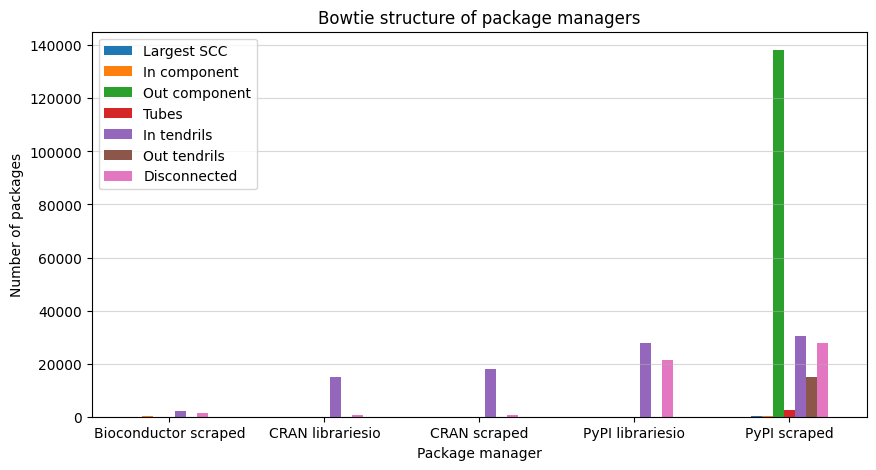

In [53]:
bowtie_table.plot.bar(figsize=(10,5), rot=0, title='Bowtie structure of package managers', ylabel='Number of packages', xlabel='Package manager')

# Add a grid
plt.grid(axis='y', alpha=0.5)
plt.show()